In [25]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.nn import functional as F
from torchvision import transforms
from src import AEModel, NormNoiseQuantization

In [106]:
def read_image(path):
    tr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    
    img = tr(Image.open(path)).unsqueeze(0)
    return img


def mse_loss(result, target):
    return F.mse_loss(result, target)


def psnr(result, target):
    mse = mse_loss(result, target)
    return 20 * torch.log10(result.max() / mse**0.5)


def BPP(path, original_path):
    file_size = os.path.getsize(path)
    return file_size * 8 / (512*512)


def normalize_img(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    img = img.detach().squeeze(0).permute(1, 2, 0).numpy().astype(int)
    return img

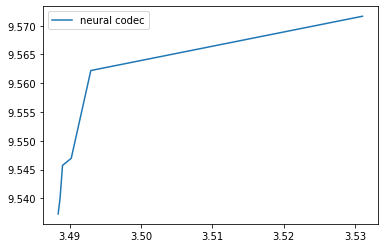

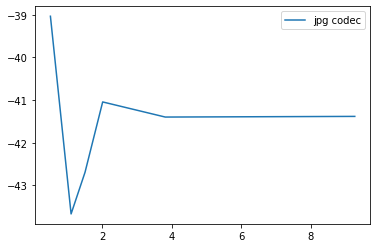

In [107]:
model = AEModel()
model.load_state_dict(torch.load('weights/ae_step95000.pt'))
model.eval()


pics = [
    'data/baboon.png',
    'data/lena.png',
    'data/peppers.png'
]


# model

quantizations = [1, 2, 3, 4, 5, 6]

psnrs = [0 for _ in quantizations]
bpps = [0 for _ in quantizations]
for path in pics:
    pic = read_image(path)
    
    for i, q in enumerate(quantizations):
        quantizator = NormNoiseQuantization(q)

        # calc psnr
        embedding = model.encode(pic)
        quantized = quantizator(embedding)
        pred = model.decode(quantized)
        psnrs[i] += psnr(pred, pic).item()
        
        # calc bpp
        Image.fromarray(normalize_img(pred), mode='RGB').save(path + '.bin.png')
        # with open(path + '.bin', 'wb') as f:
            # f.write(str(quantized.tolist()).encode())
        bpps[i] += BPP(path + '.bin.png', path)
    
psnrs = [v / 3 for v in psnrs]
bpps = [v / 3 for v in bpps]

plt.plot((bpps), (psnrs))
plt.legend(['neural codec'])
plt.show()

# jpg

jpeg_qualities = [10, 30, 50, 70, 90, 100]

psnrs = [0 for _ in jpeg_qualities]
bpps = [0 for _ in jpeg_qualities]
for path in pics:
    pic = read_image(path)
    
    for i, q in enumerate(jpeg_qualities):
        
        Image.fromarray(normalize_img(pic), mode='RGB').save(path + '.jpg', quality=q)
        pred = read_image(path + '.jpg')
        psnrs[i] += psnr(pred, pic).item()
        
        # calc bpp
        # with open(path + '.bin', 'wb') as f:
            # f.write(str(quantized.tolist()).encode())
        bpps[i] += BPP(path + '.jpg', path)
    
psnrs = [v / 3 for v in psnrs]
bpps = [v / 3 for v in bpps]


plt.plot((bpps), (psnrs))

plt.legend(['jpg codec'])